In [1]:
import random
import pickle
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import torch

%run ../metric_dissimilarity.py

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Read the training set
X_train = []
Y_train = []
for f in ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]:
  with open(f"data/{f}", "rb") as file:
    data = pickle.load(file, encoding="bytes")
    X_train.extend(data[b"data"])
    Y_train.extend(data[b"labels"])

X_test = []
Y_test = []
with open("data/test_batch", "rb") as file:
  data = pickle.load(file, encoding="bytes")
  X_test.extend(data[b"data"])
  Y_test.extend(data[b"labels"])

# Convert to numpy
X_train = np.array(X_train, dtype=np.uint8).reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
X_test = np.array(X_test, dtype=np.uint8).reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

Y_train = np.array(Y_train, dtype=np.int64)
Y_test = np.array(Y_test, dtype=np.int64)

In [3]:
np.random.seed(seed)
open_set = {}
size = round(len(np.unique(Y_train)) * (4 / 10))
for kfold in range(5):
  open_set[kfold] = np.random.choice(np.unique(Y_train), size = size, replace = False)

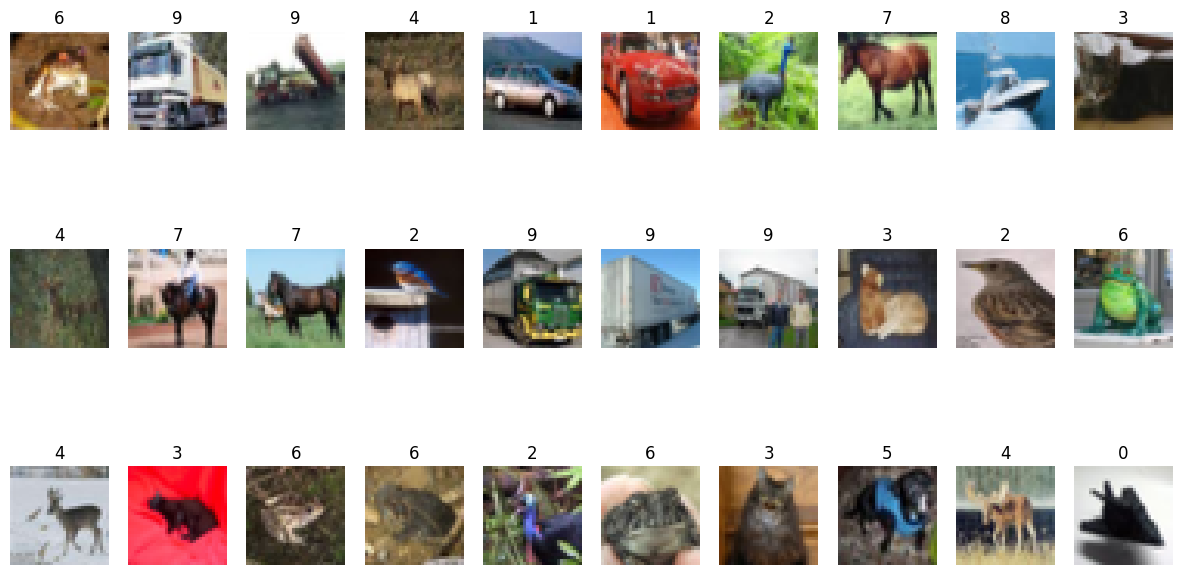

In [4]:
# Visualize some images and their corresponding labels.
plt.figure(figsize = (15, 8))
for i in range(30):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(X_train[i] / 255.)
  plt.title(Y_train[i])
  plt.axis("off")

In [5]:
# Model training
models = {}

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  X_train_known = X_train[train_known_indices]
  Y_train_known = Y_train[train_known_indices]
  
  models[kfold] = train(X_train_known, Y_train_known, 
                        model_type="triplet", backbone="VGG32", pretrained=False,
                        model_file=f"models/triplet-{kfold}.pth", top_layers=False,
                        embeddingsize=128, patch_size=(28,28),
                        batch=128, lr=0.01, iterations=250000)

Model file: models/triplet-0.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-1.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-2.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-3.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-4.pth
Loading pre-trained model...
Model is ready for evaluation.


In [6]:
# Embedding generation
train_embeddings = {}
test_embeddings = {}

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  X_train_known = X_train[train_known_indices]
  
  train_embeddings[kfold] = generate_embedding(models[kfold], X_train_known, patch_size=(28, 28), cache=f"cache/triplet/train-embedding-f{kfold}.pkl")
  test_embeddings[kfold] = generate_embedding(models[kfold], X_test, patch_size=(28, 28), cache=f"cache/triplet/test-embedding-f{kfold}.pkl")

In [ ]:
# Prototype generation
X_prot = {}
Y_prot = {}

for kfold in range(5):
  
  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  Y_train_known = Y_train[train_known_indices]
  
  X_prot[kfold], Y_prot[kfold] = compute_prototypes(train_embeddings[kfold], Y_train_known, 
                                                            n_prototypes=5, method="kmeans++", cache=f"cache/triplet/prototypes-f{kfold}.pkl")

In [8]:
# Contrastive dissimilarity space representation

acc_overall = []
msp_overall = []
mds_overall = []

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  test_known_indices = ~np.isin(Y_test, open_set[kfold])
  Y_train_known = Y_train[train_known_indices]

  X_train_space = space_representation(models[kfold], train_embeddings[kfold], X_prot[kfold], cache=f"cache/triplet/space-train-f{kfold}.pkl")
  X_test_space = space_representation(models[kfold], test_embeddings[kfold], X_prot[kfold], cache=f"cache/triplet/space-test-f{kfold}.pkl")
  
  np.random.seed(42)

  # Train a regular classifier
  clf = sklearn.linear_model.LogisticRegression(max_iter=5000)
  clf.fit(X_train_space, Y_train_known)

  # Predict
  preds = clf.predict(X_test_space)
  probs = clf.predict_proba(X_test_space)

  # Closed-set accuracy
  closed_acc = closed_accuracy(preds, Y_test, test_known_indices)

  # Open-set scores
  msp = compute_msp(probs)
  mds = compute_mds(X_train_space, X_test_space, inverted=True)

  # AUROC
  msp_auroc = open_auroc(-msp, test_known_indices, ~test_known_indices)
  mds_auroc = open_auroc(mds, test_known_indices, ~test_known_indices)

  acc_overall.append(closed_acc)
  msp_overall.append(msp_auroc)
  mds_overall.append(mds_auroc)

# Print the overall results
pct = lambda x: f"{x*100:.1f}%"
fmt = lambda x: f"{x*100:.1f}"

print("\nOverall Results:")
print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MDS AUROC':>12}")
for kfold in range(5):
  print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mds_overall[kfold]):>12}")

  # CSV
  print(f"CIFAR,All,Fold {kfold},VGG32,TDS,,Acck,,{acc_overall[kfold]}")
  print(f"CIFAR,All,Fold {kfold},VGG32,TDS,MSP,AUROC,,{msp_overall[kfold]}")
  print(f"CIFAR,All,Fold {kfold},VGG32,TDS,MDS,AUROC,,{mds_overall[kfold]}")

print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mds_overall)):<10}")
print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mds_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MDS AUROC
0            88.0%        73.3        66.2
CIFAR,All,Fold 0,VGG32,TDS,,Acck,,0.8798333333333334
CIFAR,All,Fold 0,VGG32,TDS,MSP,AUROC,,0.7332913333333333
CIFAR,All,Fold 0,VGG32,TDS,MDS,AUROC,,0.6618434166666667
1            90.8%        75.1        70.9
CIFAR,All,Fold 1,VGG32,TDS,,Acck,,0.908
CIFAR,All,Fold 1,VGG32,TDS,MSP,AUROC,,0.7510688333333334
CIFAR,All,Fold 1,VGG32,TDS,MDS,AUROC,,0.7091948541666666
2            87.5%        71.2        66.9
CIFAR,All,Fold 2,VGG32,TDS,,Acck,,0.8746666666666667
CIFAR,All,Fold 2,VGG32,TDS,MSP,AUROC,,0.71192225
CIFAR,All,Fold 2,VGG32,TDS,MDS,AUROC,,0.6693160208333333
3            93.1%        77.6        71.5
CIFAR,All,Fold 3,VGG32,TDS,,Acck,,0.931
CIFAR,All,Fold 3,VGG32,TDS,MSP,AUROC,,0.7755289583333334
CIFAR,All,Fold 3,VGG32,TDS,MDS,AUROC,,0.7149164791666667
4            87.7%        71.6        72.5
CIFAR,All,Fold 4,VGG32,TDS,,Acck,,0.8771666666666667
CIFAR,All,Fold 4,VGG32,TDS,MSP,AUROC,

In [9]:
# Contrastive dissimilarity space representation

acc_overall = []
msp_overall = []
mds_overall = []

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  test_known_indices = ~np.isin(Y_test, open_set[kfold])

  X_train_known = X_train[train_known_indices]
  Y_train_known = Y_train[train_known_indices]

  X_train_vector, Y_train_vector = vector_representation(models[kfold], X_train_known, Y_train_known,
                                                         X_prot[kfold], Y_prot[kfold], patch_size=(28, 28), variations=5,
                                                         cache=f"cache/triplet/vector-train-f{kfold}.pkl")
  X_test_vector, _ = vector_representation(models[kfold], X_test, Y_test,
                                           X_prot[kfold], Y_prot[kfold], patch_size=(28, 28), variations=5,
                                           cache=f"cache/triplet/vector-test-f{kfold}.pkl")
  
  np.random.seed(42)

  # Train a regular classifier
  clf = sklearn.linear_model.LogisticRegression(max_iter=5000)
  clf.fit(X_train_vector, Y_train_vector)

  # Predict
  raw_probs = clf.predict_proba(X_test_vector)

  # Transform the binary classification back into multiclass
  preds, probs = vector_to_class(raw_probs, Y_test, Y_prot[kfold])

  # Map the predictions to the known classes
  known_classes = np.unique(Y_train_known)
  preds = known_classes[preds]

  # Closed-set accuracy
  closed_acc = closed_accuracy(preds, Y_test, test_known_indices)

  # Open-set scores
  msp = compute_msp(probs)
  mds = compute_mds(X_train_vector, X_test_vector, Y_test, inverted=True)

  # AUROC
  msp_auroc = open_auroc(-msp, test_known_indices, ~test_known_indices)
  mds_auroc = open_auroc(mds, test_known_indices, ~test_known_indices)

  acc_overall.append(closed_acc)
  msp_overall.append(msp_auroc)
  mds_overall.append(mds_auroc)

# Print the overall results
pct = lambda x: f"{x*100:.1f}%"
fmt = lambda x: f"{x*100:.1f}"

print("\nOverall Results:")
print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MDS AUROC':>12}")
for kfold in range(5):
  print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mds_overall[kfold]):>12}")

  # CSV
  print(f"CIFAR,All,Fold {kfold},VGG32,TDV,,Acck,,{acc_overall[kfold]}")
  print(f"CIFAR,All,Fold {kfold},VGG32,TDV,MSP,AUROC,,{msp_overall[kfold]}")
  print(f"CIFAR,All,Fold {kfold},VGG32,TDV,MDS,AUROC,,{mds_overall[kfold]}")

print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mds_overall)):<10}")
print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mds_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MDS AUROC
0            86.8%        78.7        60.2
CIFAR,All,Fold 0,VGG32,TDV,,Acck,,0.8675
CIFAR,All,Fold 0,VGG32,TDV,MSP,AUROC,,0.7874138333333334
CIFAR,All,Fold 0,VGG32,TDV,MDS,AUROC,,0.6019844166666667
1            90.8%        77.9        68.4
CIFAR,All,Fold 1,VGG32,TDV,,Acck,,0.9078333333333334
CIFAR,All,Fold 1,VGG32,TDV,MSP,AUROC,,0.7790626666666667
CIFAR,All,Fold 1,VGG32,TDV,MDS,AUROC,,0.6837955833333333
2            86.9%        69.9        64.7
CIFAR,All,Fold 2,VGG32,TDV,,Acck,,0.869
CIFAR,All,Fold 2,VGG32,TDV,MSP,AUROC,,0.6987655
CIFAR,All,Fold 2,VGG32,TDV,MDS,AUROC,,0.6472132083333333
3            92.8%        79.6        62.9
CIFAR,All,Fold 3,VGG32,TDV,,Acck,,0.928
CIFAR,All,Fold 3,VGG32,TDV,MSP,AUROC,,0.7961854166666668
CIFAR,All,Fold 3,VGG32,TDV,MDS,AUROC,,0.6291215416666667
4            87.3%        72.5        69.5
CIFAR,All,Fold 4,VGG32,TDV,,Acck,,0.8726666666666667
CIFAR,All,Fold 4,VGG32,TDV,MSP,AUROC,,0.7247021249